# Example Notebook for the NRTK Perturber Functionality

This simple notebook demonstrates how to use the NRTK perturbers. For this notebook, we use a sample image from the [VisDrone](https://github.com/VisDrone/VisDrone-Dataset) dataset.

## Table of Contents

* [Set Up the Environment](#environment-setup)
* [Select Initial Image](#init-image)
* [`scikit-image` Perturbers](#scikit-image-perturbers)
    * [Salt Noise Perturber](#salt-noise-perturber)
    * [Pepper Noise Perturber](#pepper-noise-perturber)
    * [Salt and Pepper Noise Perturber](#salt-and-pepper-noise-perturber)
    * [Gaussian Noise Perturber](#gaussian-noise-perturber)
    * [Speckle Noise Perturber](#speckle-noise-perturber)
* [OpenCV Perturbers](#opencv-perturbers)
    * [Average Blur Perturber](#average-blur-perturber)
    * [Gaussian Blur Perturber](#gaussian-blur-perturber)
    * [Median Blur Perturber](#median-blur-perturber)
* [PIL Perturbers](#pil-perturbers)
    * [Brightness Perturber](#brightness-perturber)
    * [Color Perturber](#color-perturber)
    * [Contrast Perturber](#contrast-perturber)
    * [Sharpness Perturber](#sharpness-perturber)

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/perturbers.ipynb)

## Set Up the Environment <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](./README.md) for more info).

Note: We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that this cell is **not** executed so that any related warnings are shown. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk...")
!{sys.executable} -m pip install -q nrtk
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing nrtk...
Installing matplotlib...
Installing headless OpenCV...
Done!


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
import os
import urllib.request
from typing import TYPE_CHECKING, Any

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from PIL import Image

from nrtk.impls.perturb_image.generic.cv2.blur import AverageBlurPerturber, GaussianBlurPerturber, MedianBlurPerturber
from nrtk.impls.perturb_image.generic.PIL.enhance import (
    BrightnessPerturber,
    ColorPerturber,
    ContrastPerturber,
    SharpnessPerturber,
)
from nrtk.impls.perturb_image.generic.skimage.random_noise import (
    GaussianNoisePerturber,
    PepperNoisePerturber,
    SaltAndPepperNoisePerturber,
    SaltNoisePerturber,
    SpeckleNoisePerturber,
)

## Select Initial Image <a name="init-image"></a>

We'll carry out perturbations on a single image from VisDrone.

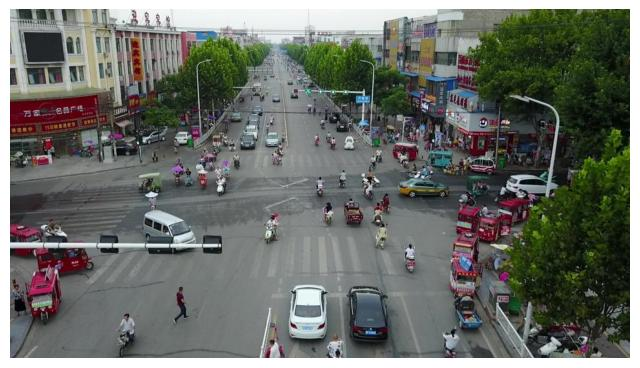

In [4]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(8, 8))
plt.axis("off")
_ = plt.imshow(img)

We'll also define a couple of helper functions for displaying our perturbations.

In [5]:
def display_pert(img: np.ndarray, descriptor: str = "") -> None:
    """Display perturbation"""
    _, axs = plt.subplots(figsize=(8, 8))
    if TYPE_CHECKING:
        assert isinstance(axs, Axes)
    axs.set_title(descriptor)
    axs.imshow(img)
    axs.axis("off")

In [6]:
def config_to_str(config: dict[str, Any]) -> str:
    """Generate string to describe config"""
    out = ", ".join([f"{k}={v}" for k, v in config.items()])

    return f"({out})"

## `scikit-image` Perturbers <a name="scikit-image-perturbers"></a>

First, we'll look at our `scikit-image` random noise perturbers. For all of these perturbers, we can specify a psuedo-random number generator (RNG) or seed if results need to be reproducible.

### Salt Noise Perturber <a name="salt-noise-perturber"></a>

The `SaltNoisePerturber` replaces random pixels with 1.

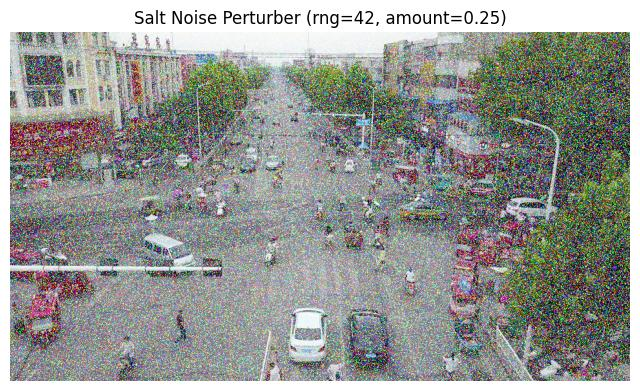

In [7]:
seed = 42
amount = 0.25

salt_noise_perturber = SaltNoisePerturber(
    rng=seed,
    amount=amount,
)
salt_noise_out, _ = salt_noise_perturber(img)
display_pert(salt_noise_out, f"Salt Noise Perturber {config_to_str(salt_noise_perturber.get_config())}")

Since we specified a seed, we can confirm that our results are reproducible:

In [8]:
salt_noise_perturber_2 = SaltNoisePerturber(
    rng=seed,
    amount=amount,
)
salt_noise_out_2, _ = salt_noise_perturber_2(img)
print(np.array_equal(salt_noise_out, salt_noise_out_2))
assert np.array_equal(salt_noise_out, salt_noise_out_2)  # noqa: S101

True


### Pepper Noise Perturber <a name="pepper-noise-perturber"></a>

The `PepperNoisePerturber` replaces random pixels with 0 (for unsigned images) or -1 (for signed images).

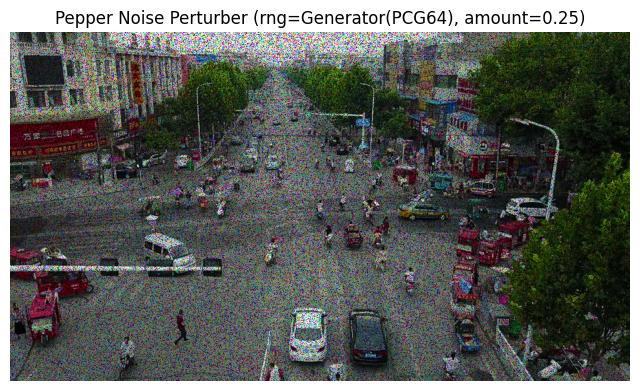

In [9]:
seed = 42
amount = 0.25

pepper_noise_perturber = PepperNoisePerturber(
    rng=np.random.default_rng(seed),
    amount=amount,
)
pepper_noise_out, _ = pepper_noise_perturber(img)
display_pert(pepper_noise_out, f"Pepper Noise Perturber {config_to_str(pepper_noise_perturber.get_config())}")

Again, we can confirm that our results are reproducible, but this time we're directly using a generator:

In [10]:
pepper_noise_perturber_2 = PepperNoisePerturber(
    rng=np.random.default_rng(seed),
    amount=amount,
)
pepper_noise_out_2, _ = pepper_noise_perturber_2(img)
print(np.array_equal(pepper_noise_out, pepper_noise_out_2))
assert np.array_equal(pepper_noise_out, pepper_noise_out_2)  # noqa: S101

True


### Salt and Pepper Noise Perturber <a name="salt-and-pepper-noise-perturber"></a>

The `SaltAndPepperNoisePerturber` replaces random pixels with either salt or pepper noise. Just as before, reproducibility is possible with the `rng` parameter, but we won't continue to demonstrate that.

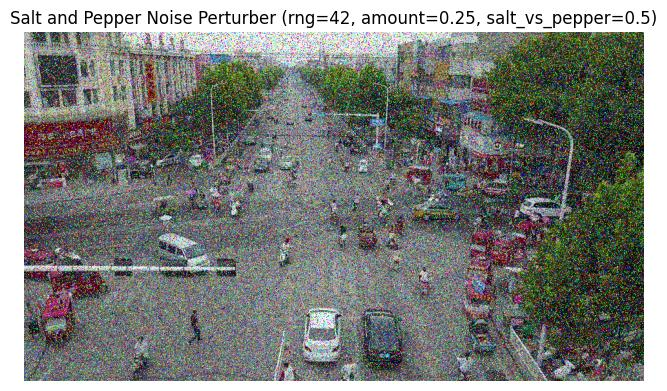

In [11]:
seed = 42
amount = 0.25
salt_vs_pepper = 0.5

sp_noise_perturber = SaltAndPepperNoisePerturber(
    rng=seed,
    amount=amount,
    salt_vs_pepper=salt_vs_pepper,
)
sp_noise_out, _ = sp_noise_perturber(img)
display_pert(sp_noise_out, f"Salt and Pepper Noise Perturber {config_to_str(sp_noise_perturber.get_config())}")

### Gaussian Noise Perturber <a name="gaussian-noise-perturber"></a>

The `GaussianNoisePerturber` adds Gaussian-distributed noise to the image.

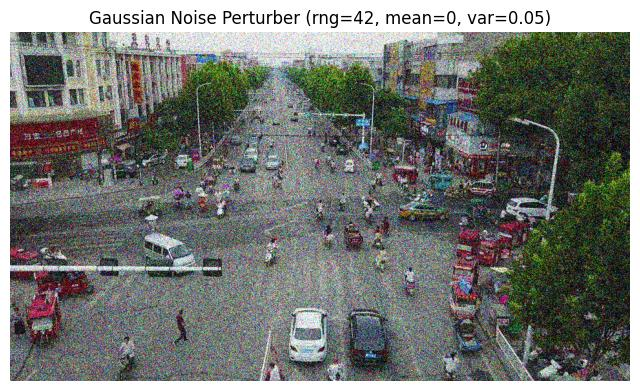

In [12]:
seed = 42
mean = 0
var = 0.05

gaussian_noise_perturber = GaussianNoisePerturber(
    rng=seed,
    mean=mean,
    var=var,
)
gaussian_noise_out, _ = gaussian_noise_perturber(img)
display_pert(gaussian_noise_out, f"Gaussian Noise Perturber {config_to_str(gaussian_noise_perturber.get_config())}")

### Speckle Noise Perturber <a name="speckle-noise-perturber"></a>

The `SpeckleNoisePerturber` adds multiplicative, Gaussian-distributed noise to the image.

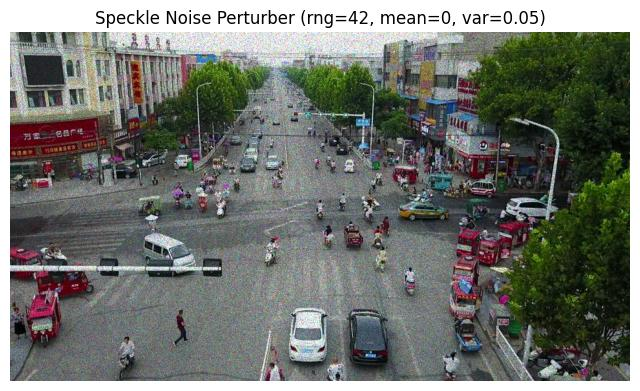

In [13]:
seed = 42
mean = 0
var = 0.05

speckle_noise_perturber = SpeckleNoisePerturber(
    rng=seed,
    mean=mean,
    var=var,
)
speckle_noise_out, _ = speckle_noise_perturber(img)
display_pert(speckle_noise_out, f"Speckle Noise Perturber {config_to_str(speckle_noise_perturber.get_config())}")

## OpenCV Perturbers <a name="opencv-perturbers"></a>

Next, we'll look at our OpenCV blur perturbers.

### Average Blur Perturber <a name="average-blur-perturber"></a>

The `AverageBlurPerturber` applies "average" blurring to the image stimulus. To achieve this, OpenCV convolves the image with a normalized box filter, so the average of the pixels under the kernel replaces the central element.

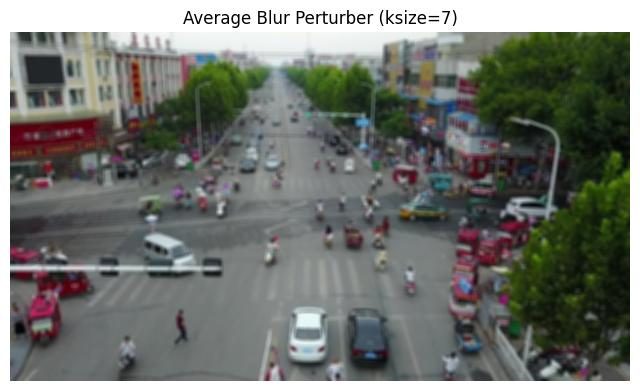

In [14]:
ksize = 7

avg_blur_perturber = AverageBlurPerturber(
    ksize=ksize,
)
avg_blur_out, _ = avg_blur_perturber(img)
display_pert(avg_blur_out, f"Average Blur Perturber {config_to_str(avg_blur_perturber.get_config())}")

### Gaussian Blur Perturber <a name="gaussian-blur-perturber"></a>

The `GaussianBlurPerturber` applies Gaussian blurring to the image stimulus by using a Gaussian kernel instead of a normalized box filter.

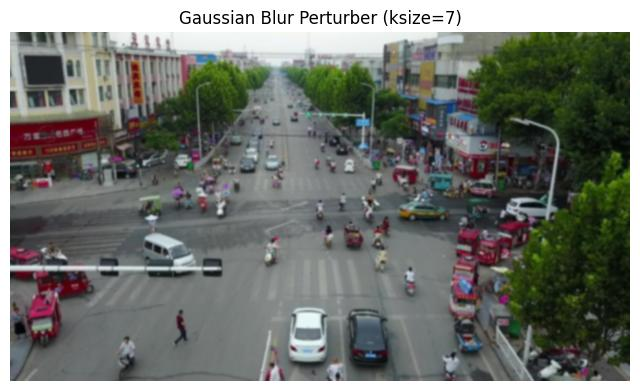

In [15]:
ksize = 7

gaussian_blur_perturber = GaussianBlurPerturber(
    ksize=ksize,
)
gaussian_blur_out, _ = gaussian_blur_perturber(img)
display_pert(gaussian_blur_out, f"Gaussian Blur Perturber {config_to_str(gaussian_blur_perturber.get_config())}")

### Median Blur Perturber <a name="median-blur-perturber"></a>

The `MedianBlurPerturber` applies median blurring to the image stimulus, where the central element is replaced with the median value of the pixels under the kernel.

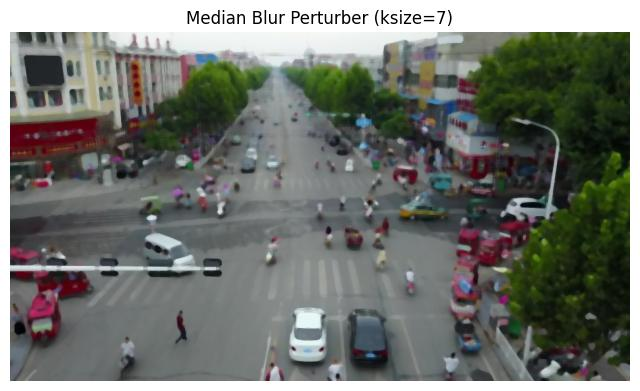

In [16]:
ksize = 7

median_blur_perturber = MedianBlurPerturber(
    ksize=ksize,
)
median_blur_out, _ = median_blur_perturber(img)
display_pert(median_blur_out, f"Median Blur Perturber {config_to_str(median_blur_perturber.get_config())}")

## PIL Perturbers <a name="pil-perturbers"></a>

Next, we'll look at our Python Imaging Library (PIL) enhance perturbers. A factor of 1.0 returns a copy of the original image. Lower factor values mean less of the relevant enhancement (e.g. brightness) while higher values mean more.

### Brightness Perturber <a name="brightness-perturber"></a>

The `BrightnessPerturber` adjusts the brightness of the image stimulus. 

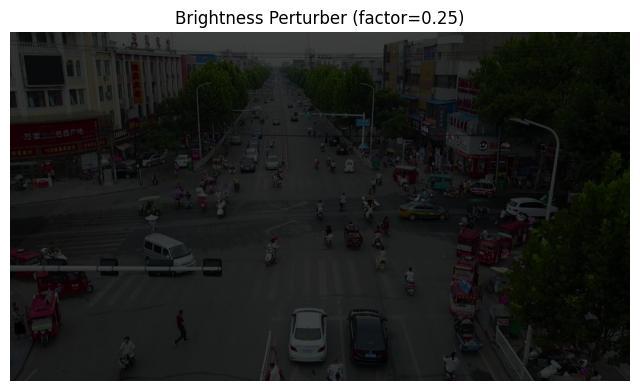

In [17]:
factor = 0.25

brightness_perturber = BrightnessPerturber(
    factor=factor,
)
brightness_out, _ = brightness_perturber(img)
display_pert(brightness_out, f"Brightness Perturber {config_to_str(brightness_perturber.get_config())}")

### Color Perturber <a name="color-perturber"></a>

The `ColorPerturber` adjusts the color balance of the image stimulus. 

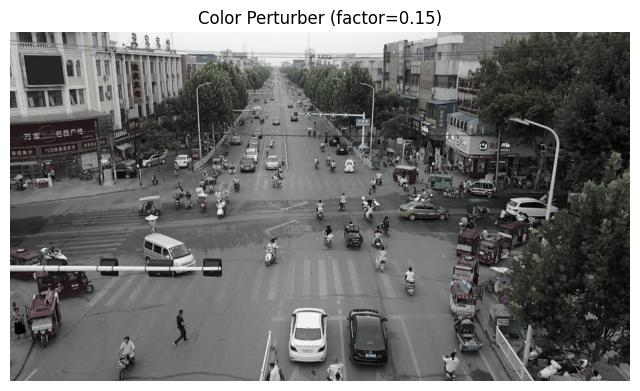

In [18]:
factor = 0.15

color_perturber = ColorPerturber(
    factor=factor,
)
color_out, _ = color_perturber(img)
display_pert(color_out, f"Color Perturber {config_to_str(color_perturber.get_config())}")

### Contrast Perturber <a name="contrast-perturber"></a>

The `ContrastPerturber` adjusts the contrast of the image stimulus. 

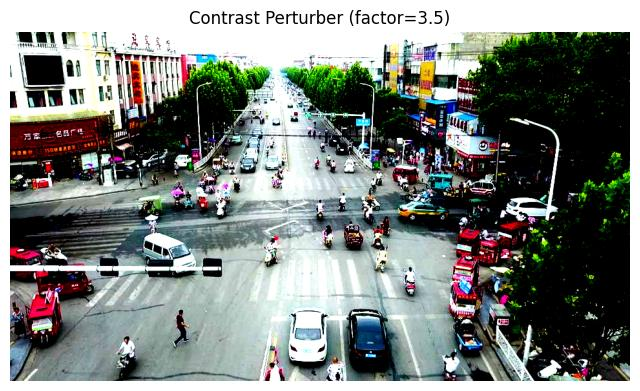

In [19]:
factor = 3.5

contrast_perturber = ContrastPerturber(
    factor=factor,
)
contrast_out, _ = contrast_perturber(img)
display_pert(contrast_out, f"Contrast Perturber {config_to_str(contrast_perturber.get_config())}")

### Sharpness Perturber <a name="sharpness-perturber"></a>

The `SharpnessPerturber` adjusts the sharpness of the image stimulus. The sharpness factor is limited to [0.0, 2.0]. 

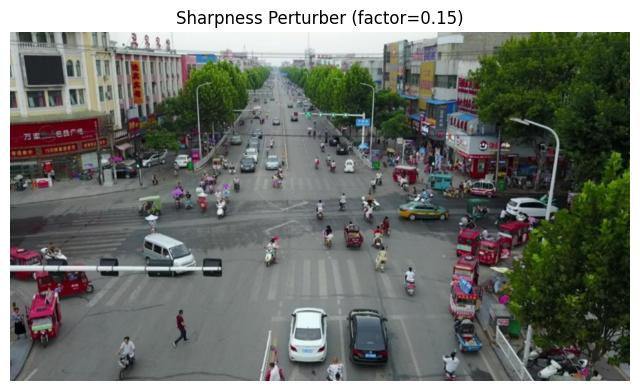

In [20]:
factor = 0.15

sharpness_perturber = SharpnessPerturber(
    factor=factor,
)
sharpness_out, _ = sharpness_perturber(img)
display_pert(sharpness_out, f"Sharpness Perturber {config_to_str(sharpness_perturber.get_config())}")